In [82]:
#!pip install geopandas

In [83]:
import pandas as pd
import geopandas as gpd
import json
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np

In [84]:
db = pd.read_csv("database.csv")
rydde = db[931:17798]

In [85]:
gdf = gpd.GeoDataFrame(rydde, geometry=gpd.points_from_xy(rydde.longitude, rydde.latitude))

In [86]:
gdf.date = pd.to_datetime(gdf.date)

In [87]:
#Svinøya 30x30
lat_min = 62.345252708439276
lat_max = 62.61474729156072
lng_min = 5.978375939307136
lng_max = 6.561624060692863
cell_rows, cell_columns = 32, 32
# cell_rows, cell_columns = 16, 16

In [88]:
def generateCells(lat_min, lng_min, lat_max, lng_max, cell_rows, cell_columns):
    half_cell_height = (lat_max - lat_min) / (2 * (cell_rows - 1))
    half_cell_width = (lng_max - lng_min) / (2 * (cell_columns - 1))
    lat_point = lat_min
    row_count = 0
    cells = []
    while (row_count < cell_rows):
        lng_point = lng_min
        column_count = 0
        while (column_count < cell_columns):
            lat_0 = lat_point - half_cell_height
            lng_0 = lng_point - half_cell_width
            lat_1 = lat_point + half_cell_height
            lng_1 = lng_point + half_cell_width
            cells.append({"lng_min":lng_0, "lat_min": lat_0, "lat_max":lat_1, "lng_max":lng_1})
            lng_point += 2 * half_cell_width
            column_count+=1
        lat_point += 2 * half_cell_height
        row_count+=1
    return cells
    

In [89]:
cells = generateCells(lat_min, lng_min, lat_max, lng_max, cell_rows, cell_columns)

In [90]:
# pd.Series(json.dumps(cells)).to_csv("cells.csv")

In [91]:
def getCellData(cell):
        data = gdf.cx[cell["lng_min"]: cell["lng_max"], cell["lat_min"] : cell["lat_max"]]
        return data

In [92]:
def createBoundsDf(cells):
    i = 0;
    udf = pd.DataFrame(columns=["date", "boundsId", "weight", "quantity"])
    for cell in cells:
        data = getCellData(cell)
        # print(data)
        newdf = pd.DataFrame(data)
        newdf["boundsId"] = i
        newdf = newdf[["date", "boundsId", "weight", "quantity"]]
        udf = udf.append(newdf, ignore_index=True)
        i+=1
    return udf

In [93]:
bdf = createBoundsDf(cells)
bdf.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_11664\187190331.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  udf = udf.append(newdf, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11664\187190331.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  udf = udf.append(newdf, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11664\187190331.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  udf = udf.append(newdf, ignore_index=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_11664\187190331.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  udf = udf.append(newdf, ignore_index=True)
C:\Users\Dell\AppData\Lo

,date,boundsId,weight,quantity
0,2018-04-10 02:00:00,37,1000.0,NaN
1,2014-05-07 02:00:00,37,0.0,NaN
2,2016-05-07 02:00:00,99,0.0,NaN
3,2017-09-16 02:00:00,99,1450.0,NaN
4,2019-07-01 02:00:00,99,700.0,NaN


In [94]:
# bdf.to_csv("cells_database.csv")

In [24]:
from sklearn import preprocessing

new_bdf = bdf.sort_values(by="date")
new_bdf["weight"] = new_bdf["weight"].replace(np.nan, 0.0)

def normalize(df, feature_name):
    result = df.copy()
    max_value = df[feature_name].max()
    min_value = df[feature_name].min()
    result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


new_bdf = normalize(new_bdf, "weight")


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [25]:
# new_bdf.set_index("date")
term_date = datetime.datetime(2019, 1, 1)
temp = new_bdf[new_bdf["date"]< term_date]
temp["weight"] = temp["weight"].replace(np.nan, 0.0)



C:\Users\Dell\AppData\Local\Temp\ipykernel_21964\3425218376.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["weight"] = temp["weight"].replace(np.nan, 0.0)


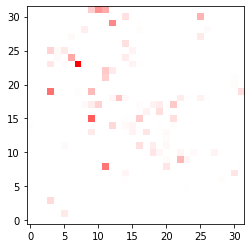

In [26]:
temp_data = np.zeros((cell_rows, cell_columns))

for i in range(len(temp)):
  id = temp["boundsId"].iloc[i]
  row = int(id/cell_rows)
  col = int(id%cell_columns)
  # print(row, col)
  if temp["weight"].iloc[i]:
    temp_data[row, col] = temp_data[row, col] +  temp["weight"].iloc[i]

temp_data

N = 256
vals = np.ones((N, 3))
vals[:, 0] = np.linspace(0, 1, 1)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(0, 1, N)
newcmp = ListedColormap((2+(vals*-2))/2)
# newcmp = ListedColormap(vals)
# print((2+(vals*-2))/2)
# print(vals)

plt.imshow(temp_data, cmap=newcmp, interpolation='nearest', origin="lower")
plt.show()
# print(temp_data)

In [27]:
def generate_heatmaps(df):
  Years = list(range(2014, 2021))
  Months = list(range(1,13))
  monthly_heatmaps = []
  for year in Years:
    for month in Months:
      stop_date = datetime.datetime(year,month,1)
      filtered_data = df[df["date"]<stop_date]
      # filtered_data["weight"] = filtered_data["weight"].replace(np.nan, 0.0)
      temp_data = np.zeros((cell_rows, cell_columns))
      # print(stop_date)
      for i in range(len(filtered_data)):
        pass
        id = filtered_data.iloc[i]["boundsId"]
        row = int(id/cell_rows)
        col = int(id%cell_columns)
        # print(row, col)
        if filtered_data["weight"].iloc[i]:
          temp_data[row, col] = temp_data[row, col] +  filtered_data.iloc[i]["weight"]

      monthly_heatmaps.append((temp_data))
  # not normalized yet
  return monthly_heatmaps


In [28]:
heatmaps = generate_heatmaps(new_bdf)
new_data = np.array(heatmaps)
print(new_data.shape)
# print(heatmaps[-1])

(84, 32, 32)


In [29]:
train_ratio = 0.75

train_size = int(len(new_data) * train_ratio)
test_size = len(new_data) - train_size
train = new_data[0:train_size,:]
test = new_data[train_size:len(new_data),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 63, test size: 21 


In [30]:
seq_len = 4
seq_future = 1
# dataX = []
# dataY = []
# for i in range(len(train)-seq_len-1):
#     a = train[i:(i+seq_len), :, :]
#     dataX.append(a)
#     dataY.append(train[i + seq_len, :, :])
# trainX = np.array(dataX)
# trainX = trainX[::, ::, ::, ::, np.newaxis]
# trainY = np.array(dataY)
# trainY = trainY[::, ::, ::, np.newaxis]

# dataX = []
# dataY = []
# for i in range(len(test)-seq_len-1):
#     a = test[i:(i+seq_len), :, :]
#     dataX.append(a)
#     dataY.append(test[i + seq_len, :,:])

# # dataX = [dataX]
# # dataY = [:,dataX]
# testX = np.array(dataX)
# testX = testX[::, ::, ::, ::, np.newaxis]
# testY = np.array(dataY)
# testY = testY[::, ::, ::, np.newaxis]



dataX = []
dataY = []
for i in range(len(train)-seq_len-1):
    a = train[i:(i+seq_len), :, :]
    dataX.append(a)
    dataY.append(train[i+seq_future: (i + seq_future +seq_len), :, :])
trainX = np.array(dataX)
trainX = trainX[::, ::, ::, ::, np.newaxis]
trainY = np.array(dataY)
trainY = trainY[::, ::, ::,::, np.newaxis]

dataX = []
dataY = []
for i in range(len(test)-seq_len-1):
    a = test[i:(i+seq_len), :, :]
    dataX.append(a)
    dataY.append(test[i+seq_future: (i + seq_future +seq_len), :, :])

# dataX = [dataX]
# dataY = [:,dataX]
testX = np.array(dataX)
testX = testX[::, ::, ::, ::, np.newaxis]
testY = np.array(dataY)
testY = testY[::, ::, ::, ::, np.newaxis]


# dataX = []
# dataY = []
# for i in range(len(train)-seq_len-1):
#     a = train[i:(i+seq_len + seq_future), :, :]
#     dataX.append(a)
#     dataY.append(train[(i + seq_future +seq_len), :, :])
# trainX = np.array(dataX)
# trainX = trainX[::, ::, ::, ::, np.newaxis]
# trainY = np.array(dataY)
# trainY = trainY[::, ::, ::, np.newaxis]

# dataX = []
# dataY = []
# for i in range(len(test)-seq_len-1):
#     a = test[i:(i+seq_len + seq_future), :, :]
#     dataX.append(a)
#     dataY.append(test[(i + seq_future +seq_len), :, :])

# # dataX = [dataX]
# # dataY = [:,dataX]
# testX = np.array(dataX)
# testX = testX[::, ::, ::, ::, np.newaxis]
# testY = np.array(dataY)
# testY = testY[::, ::, ::, np.newaxis]


print('shape of trainX: ', trainX.shape)
print('shape of testX: ', testX.shape)
print('shape of trainY: ', trainY.shape)
print('shape of testY: ', testY.shape)

shape of trainX:  (58, 4, 32, 32, 1)
shape of testX:  (16, 4, 32, 32, 1)
shape of trainY:  (58, 4, 32, 32, 1)
shape of testY:  (16, 4, 32, 32, 1)


In [31]:
trainX[np.isnan(trainX)] = 0
testX[np.isnan(testX)] = 0
testX[np.isnan(testX)] = 0
testY[np.isnan(testY)] = 0


In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import ConvLSTM2D, Conv3D, Conv2D
import keras
from keras.callbacks import EarlyStopping

F:\Softwares\Anaconda\envs\testENV\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.1 when it was built against 1.12.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [ ]:
seq = Sequential(
    [
     keras.Input(
         shape=(None, cell_rows, cell_columns, 1)
     ),
     ConvLSTM2D(filters=4, kernel_size=(2 ,2), padding="same", return_sequences=True),
     BatchNormalization(),
     ConvLSTM2D(filters=4, kernel_size=(2 ,2), padding="same", return_sequences=True),
     BatchNormalization(),
     ConvLSTM2D(filters=4, kernel_size=(2 ,2), padding="same", return_sequences=True),
     BatchNormalization(),
     ConvLSTM2D(filters=4, kernel_size=(2 ,2), padding="same", return_sequences=True),
    #  ConvLSTM2D(filters=4, kernel_size=(2 ,2), padding="same", return_sequences=False),
     BatchNormalization(),
     Conv3D(filters=1, kernel_size=(2,2,4), activation="sigmoid", padding="same"),
    #  Conv2D(filters=1, kernel_size=(2,2), activation="sigmoid", padding="same"),
    ]
    # ]
)

seq.compile(loss="binary_crossentropy", optimizer="adam")
# seq.compile(loss="mae", optimizer="adam")
seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 32, 32, 4)   336       
                                                                 
 batch_normalization (BatchN  (None, None, 32, 32, 4)  16        
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 32, 32, 4)   528       
                                                                 
 batch_normalization_1 (Batc  (None, None, 32, 32, 4)  16        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 32, 32, 4)   528       
                                                                 
 batch_normalization_2 (Batc  (None, None, 32, 32, 4)  1

In [ ]:
epoch = 18

history = seq.fit(
    trainX,
    trainY,
    batch_size=1,
    # validation_split=0.1
    epochs=epoch,
    validation_data = (testX, testY), shuffle=False
)

Epoch 1/18
58/58 [==============================] - 12s 74ms/step - loss: 0.5467 - val_loss: 0.5738
Epoch 2/18
58/58 [==============================] - 3s 57ms/step - loss: 0.1681 - val_loss: 0.4282
Epoch 3/18
58/58 [==============================] - 3s 59ms/step - loss: 0.0618 - val_loss: 0.2907
Epoch 4/18
58/58 [==============================] - 4s 61ms/step - loss: 0.0367 - val_loss: 0.1933
Epoch 5/18
58/58 [==============================] - 3s 60ms/step - loss: 0.0263 - val_loss: 0.1508
Epoch 6/18
58/58 [==============================] - 4s 61ms/step - loss: 0.0204 - val_loss: 0.1491
Epoch 7/18
58/58 [==============================] - 4s 62ms/step - loss: 0.0169 - val_loss: 0.1773
Epoch 8/18
58/58 [==============================] - 4s 61ms/step - loss: 0.0146 - val_loss: 0.2277
Epoch 9/18
58/58 [==============================] - 4s 63ms/step - loss: 0.0130 - val_loss: 0.2678
Epoch 10/18
58/58 [==============================] - 6s 100ms/step - loss: 0.0119 - val_loss: 0.2367
Epoch 1

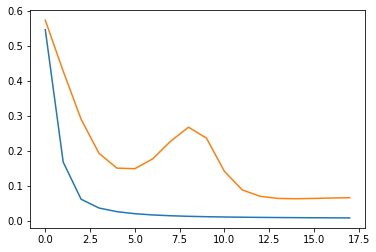

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [ ]:
predicted = seq.predict(testX)
predicted.shape

(16, 4, 32, 32, 1)

In [ ]:
predicted = np.squeeze(predicted, axis =4)
# predicted = np.squeeze(predicted, axis =3)
predicted.shape

(16, 4, 32, 32)

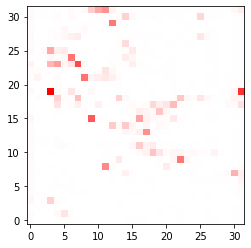

In [ ]:
predicted_instance = predicted[0][3]
# predicted_instance = predicted[1]

N = 256
vals = np.ones((N, 3))
vals[:, 0] = np.linspace(0, 1, 1)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(0, 1, N)
newcmp = ListedColormap((2+(vals*-2))/2)
# newcmp = ListedColormap(vals)
# print((2+(vals*-2))/2)
# print(vals)

plt.imshow(predicted_instance, cmap=newcmp, interpolation='nearest', origin="lower")
plt.show()
# print(temp_data)


(16, 4, 32, 32)


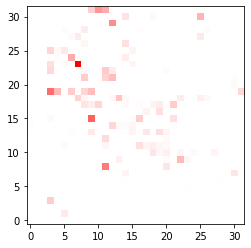

In [ ]:
ground_truth = np.squeeze(testY, axis =4)
print(ground_truth.shape)
# ground_truth = np.squeeze(testY, axis =3)
true_instance = ground_truth[0][3]
# true_instance = ground_truth[1]
plt.imshow(true_instance, cmap=newcmp, interpolation='nearest', origin="lower")
plt.show()

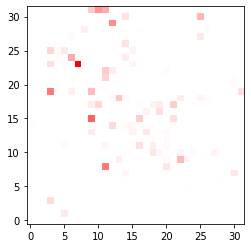

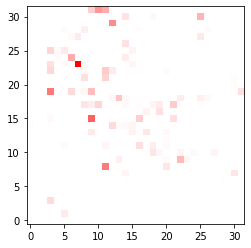

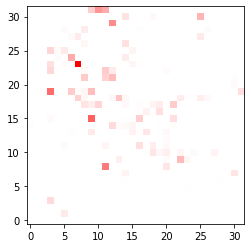

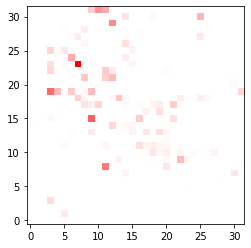

In [ ]:
input_sequence = np.squeeze(testX, axis = 4)

# ground_truth = np.squeeze(testY, axis =3)
for i in list(range(4)):
  input_map = input_sequence[0][i]
  # true_instance = ground_truth[1]
  plt.imshow(input_map, cmap=newcmp, interpolation='nearest', origin="lower")
  plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
for i in range(ground_truth.shape[0]):
  for j in range(ground_truth.shape[1]):
    pass


err = np.sum(np.abs(np.subtract(ground_truth[0], predicted[0])))/(cell_rows * cell_columns)
err

0.058309121079849244